In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



In [43]:
file_path='../data/raw/transactions.csv'
df= pd.read_csv(file_path)

In [44]:
print(" Rows and columns:", df.shape)
print("\n Column names:", df.columns.tolist())

 Rows and columns: (2512, 16)

 Column names: ['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


In [45]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [46]:
#null check 
nulls= df.isnull().sum()

#datatypes check
types = df.dtypes

#unique value per column (for categories detection)
unique_counts = df.nunique().sort_values()

print("Nulls:\n", nulls[nulls>0])
print("\n Column types:\n", types)
print("\n unique value counts: \n", unique_counts)

Nulls:
 Series([], dtype: int64)

 Column types:
 TransactionID               object
AccountID                   object
TransactionAmount          float64
TransactionDate             object
TransactionType             object
Location                    object
DeviceID                    object
IP Address                  object
MerchantID                  object
Channel                     object
CustomerAge                  int64
CustomerOccupation          object
TransactionDuration          int64
LoginAttempts                int64
AccountBalance             float64
PreviousTransactionDate     object
dtype: object

 unique value counts: 
 TransactionType               2
Channel                       3
CustomerOccupation            4
LoginAttempts                 5
Location                     43
CustomerAge                  63
MerchantID                  100
TransactionDuration         288
PreviousTransactionDate     360
AccountID                   495
IP Address                  592

In [47]:
df['TransactionDate']=pd.to_datetime(df['TransactionDate'],errors='coerce')
df['PreviousTransactionDate']=pd.to_datetime(df['PreviousTransactionDate'],errors='coerce')

print("converted TransactionDate:",df['TransactionDate'].dtype)
print("converted PreviousTransactionDate", df['PreviousTransactionDate'].dtype)

#check for missing transaction date 
print("\n Missing TransactionDate:",df['TransactionDate'].isnull().sum())
print("\n Missing PreviousTransactionDate:",df['TransactionDate'].isnull().sum())

#check for negative transaction amount
print("\n non postive amounts:\n", df[df['TransactionAmount']<= 0].shape[0])

#chekc for unrealsitic age
print("\n Unrealistic age (<10 and >100):\n", df[(df['CustomerAge']< 10) | (df['CustomerAge']> 100 )].shape[0])

print("\n negative account balance :\n", df[df['AccountBalance']< 0].shape[0])


converted TransactionDate: datetime64[ns]
converted PreviousTransactionDate datetime64[ns]

 Missing TransactionDate: 0

 Missing PreviousTransactionDate: 0

 non postive amounts:
 0

 Unrealistic age (<10 and >100):
 0

 negative account balance :
 0


In [48]:
#step 9 Mini Feature Engineering- Behavior and Time Features
# 1. Extract hour and day of the week

df['TransactionHour'] =df['TransactionDate'].dt.hour
df['TransactionDayOfWeek'] = df['TransactionDate'].dt.dayofweek # monday=0 , sunday=6

# 2. calculate the time from last transaction
df['TimeSinceLastTransaction'] = (df['TransactionDate']- df['PreviousTransactionDate']).dt.total_seconds()

# 3. Create flag: high login attempts (>=3)
df['HighLoginAttempts']=(df['LoginAttempts']>= 3).astype(int)

# 4. Create flag: long transaction duration (>95th percentile)
duration_threshold = df['TransactionDuration'].quantile(0.95)
df['LongDuration'] = (df['TransactionDuration'] > duration_threshold).astype(int)

# 5. Encode TransactionType (Credit = 1, Debit = 0)
df['IsCredit'] = (df['TransactionType'] == 'Credit').astype(int)

# View first few rows with new features
df[['TransactionDate', 'TransactionHour', 'TransactionDayOfWeek', 
    'TimeSinceLastTransaction', 'HighLoginAttempts', 
    'TransactionDuration', 'LongDuration', 'TransactionType', 'IsCredit']].head(10)


,TransactionDate,TransactionHour,TransactionDayOfWeek,TimeSinceLastTransaction,HighLoginAttempts,TransactionDuration,LongDuration,TransactionType,IsCredit
0,2023-04-11 16:29:14,16,1,-49477134.0,0,81,0,Debit,0
1,2023-06-27 16:44:19,16,1,-42823516.0,0,141,0,Debit,0
2,2023-07-10 18:16:08,18,0,-41694656.0,0,56,0,Debit,0
3,2023-05-05 16:32:11,16,4,-47403415.0,0,25,0,Debit,0
4,2023-10-16 17:51:24,17,0,-33228915.0,0,198,0,Credit,1
5,2023-04-03 17:15:01,17,0,-50165495.0,0,172,0,Debit,0
6,2023-02-15 16:36:48,16,2,-54228801.0,0,139,0,Credit,1
7,2023-05-08 17:47:59,17,0,-47139776.0,0,291,1,Credit,1
8,2023-03-21 16:59:46,16,1,-51289888.0,0,86,0,Credit,1
9,2023-03-31 16:06:57,16,4,-50428775.0,0,120,0,Debit,0


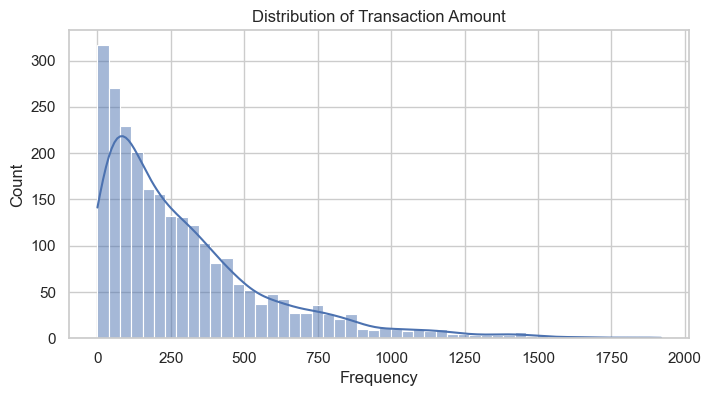

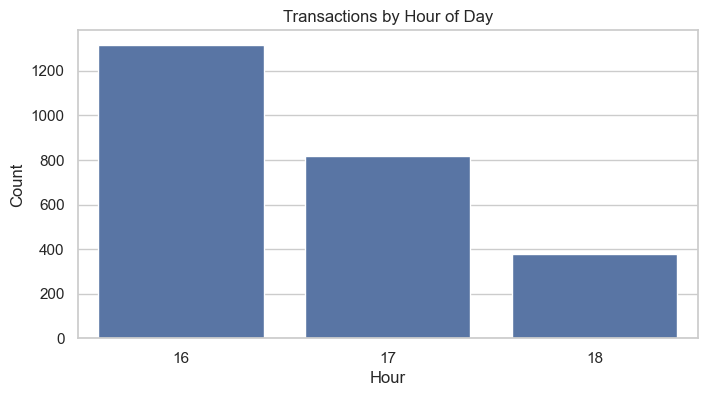

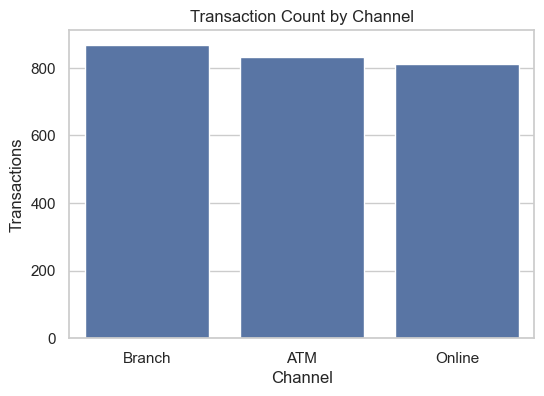

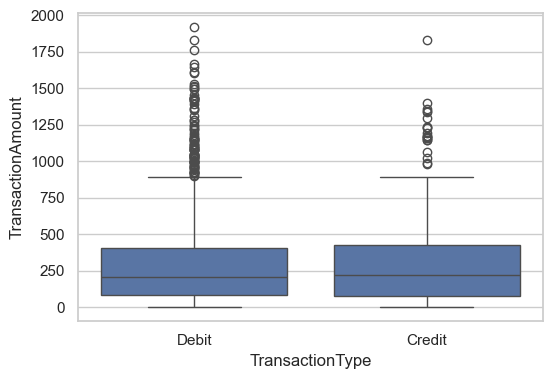

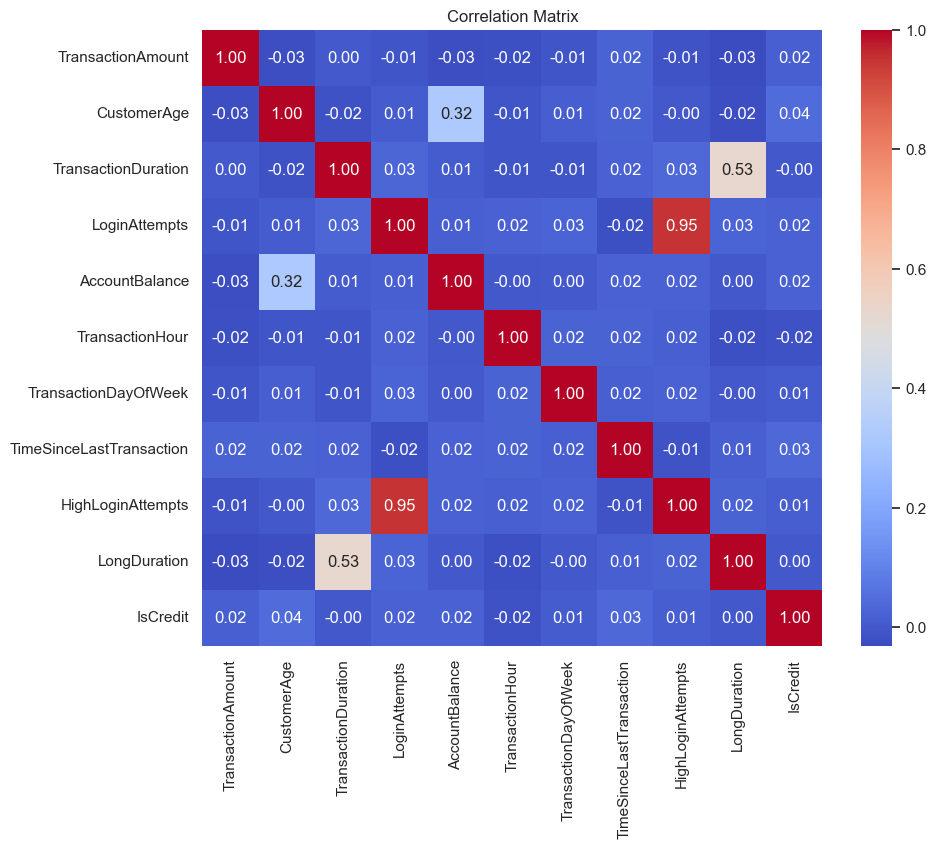

In [49]:
sns.set(style="whitegrid")

# 1. Distribution of transaction amounts
plt.figure(figsize=(8,4))
sns.histplot(df['TransactionAmount'], bins=50, kde= True)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.xlabel("Frequency")
plt.show()

# 2. Transaction hour distribution
plt.figure(figsize=(8,4))
sns.countplot(x='TransactionHour', data=df)
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

# 3. Transactions by channel
plt.figure(figsize=(6,4))
sns.countplot(x='Channel',data=df, order=df['Channel'].value_counts().index)
plt.title("Transaction Count by Channel")
plt.ylabel("Transactions")
plt.show()

# 4. Boxplot of transaction amount by transaction type
plt.figure(figsize=(6,4))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df)
plt.title("")
plt.show()

# 5. Heatmap of correlations (numeric only)
plt.figure(figsize=(10, 8))
corr_matrix=df.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()



In [50]:
df.columns

Index(['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
       'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
       'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate',
       'TransactionHour', 'TransactionDayOfWeek', 'TimeSinceLastTransaction',
       'HighLoginAttempts', 'LongDuration', 'IsCredit'],
      dtype='object')

In [51]:
#Clustering-Ready Preprocessing
df_cluster=df.copy()
#Encode categorical features
le_channel=LabelEncoder()
le_txn_type=LabelEncoder()
df_cluster['ChannelEncoded']= le_channel.fit_transform(df_cluster['Channel'])
df_cluster['TxnTypeEncoded'] = le_txn_type.fit_transform(df_cluster['TransactionType'])

#Select only numeric and encoded columns 
fetaures_to_cluster = ['TransactionAmount', 'TransactionHour', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance', 'CustomerAge',
    'TimeSinceLastTransaction', 'ChannelEncoded', 'TxnTypeEncoded']
# Fill any potential missing values in clustering features
df_cluster[fetaures_to_cluster]= df_cluster[fetaures_to_cluster].fillna(0)
scaler=StandardScaler()
X_scaled= scaler.fit_transform(df_cluster[fetaures_to_cluster])

/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/dipanshuparashar/Library

K=2 --> Silhouette Score = 0.115
K=3 --> Silhouette Score = 0.132
K=4 --> Silhouette Score = 0.131


/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DES

K=5 --> Silhouette Score = 0.129
K=6 --> Silhouette Score = 0.131

 Best number of clusters: K=3 with silhouette score=0.132


/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DES

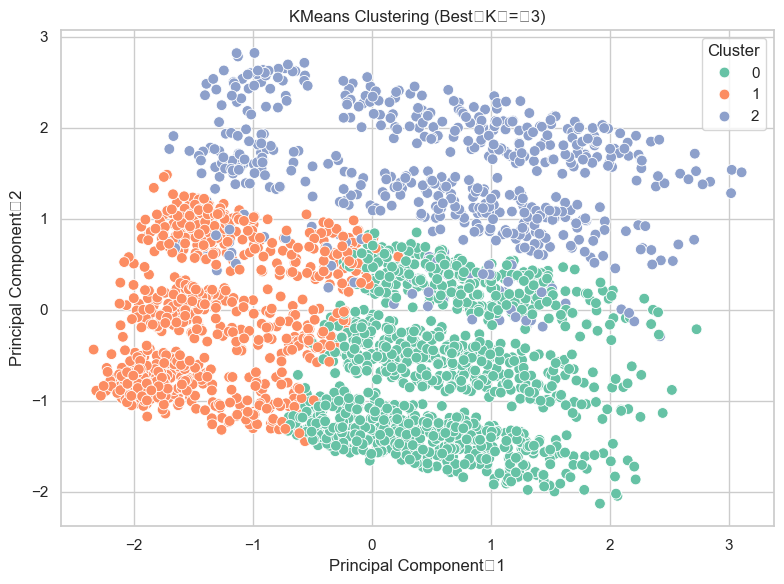

In [52]:
# STEP 1 — Try different cluster counts (2–6) to find the best K

scores={}
for k in range(2,7):
    km= KMeans(n_clusters=k, random_state=42, n_init=10)
    labels=km.fit_predict(X_scaled)
    sil=silhouette_score(X_scaled, labels)
    scores[k]= sil
    print(f"K={k} --> Silhouette Score = {sil:.3f}")

# STEP 2 — Pick the best K (highest silhouette score)
best_k = max(scores, key=scores.get)
print(f"\n Best number of clusters: K={best_k} with silhouette score={scores[best_k]:.3f}")

# STEP 3 — Fit final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# STEP 4 — Add cluster labels back to the DataFrame
df_cluster['Cluster'] = labels

# STEP 5 — Reduce to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = labels

# STEP 6 — Plot clusters in 2D PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title(f"KMeans Clustering (Best K = {best_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


Cluster Mean Profiles:
         TransactionAmount  TransactionHour  TransactionDuration  \
Cluster                                                            
0                   277.73            16.63               121.24   
1                   321.08            16.64               117.42   
2                   306.50            16.60               119.39   

         LoginAttempts  AccountBalance  CustomerAge  TimeSinceLastTransaction  \
Cluster                                                                         
0                 1.12         7036.12        55.18              -41777862.97   
1                 1.12         2110.14        27.71              -43051412.57   
2                 1.14         5249.33        46.15              -41549487.77   

         ChannelEncoded  TxnTypeEncoded  
Cluster                                  
0                  0.85             1.0  
1                  0.98             1.0  
2                  1.30             0.0  


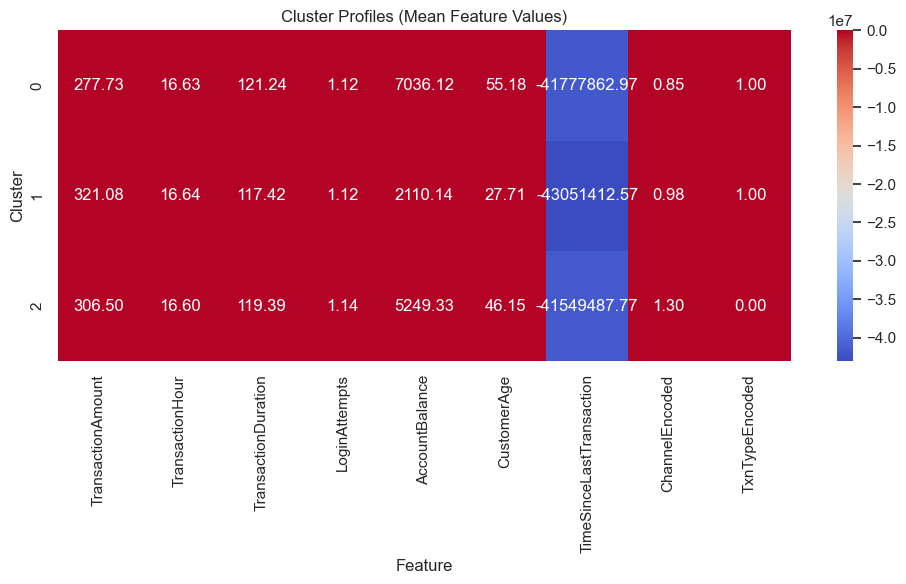

In [53]:
# Define the features you want to profile by cluster
profile_features = ['TransactionAmount', 'TransactionHour', 'TransactionDuration',
                    'LoginAttempts', 'AccountBalance', 'CustomerAge',
                    'TimeSinceLastTransaction', 'ChannelEncoded', 'TxnTypeEncoded']

# Get the mean values of each feature by cluster
cluster_profiles = df_cluster.groupby('Cluster')[profile_features].mean().round(2)

# Print the cluster profile summary
print("\nCluster Mean Profiles:")
print(cluster_profiles)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cluster Profiles (Mean Feature Values)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()



In [54]:
# Copy original DF
df_cluster['RuleBasedFraud'] = 0

# Rule logic (you can tune these thresholds)
df_cluster.loc[
    (df_cluster['LoginAttempts'] > 5) |
    (df_cluster['AccountBalance'] < 1000) |
    (df_cluster['CustomerAge'] < 30) |
    (df_cluster['TransactionAmount'] > 1000),  # unusually high txn
    'RuleBasedFraud'
] = 1


In [55]:
fraud_cluster_summary = df_cluster.groupby('Cluster')['RuleBasedFraud'].agg(['count', 'sum', 'mean']).reset_index()
fraud_cluster_summary.columns = ['Cluster', 'TotalTxns', 'FraudTxns', 'FraudRate']
print(fraud_cluster_summary)


   Cluster  TotalTxns  FraudTxns  FraudRate
0        0       1170         74   0.063248
1        1        774        627   0.810078
2        2        568        189   0.332746


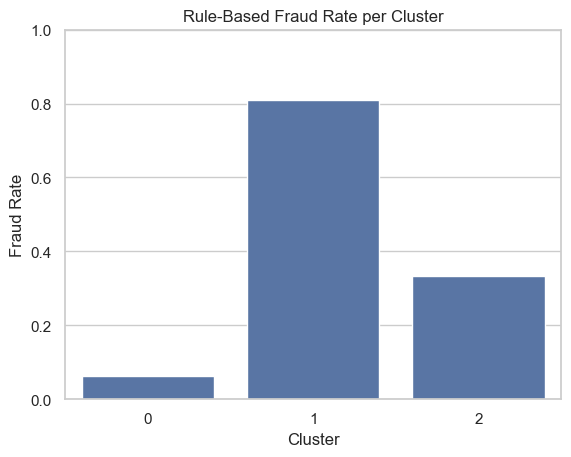

In [56]:
sns.barplot(data=fraud_cluster_summary, x='Cluster', y='FraudRate')
plt.title("Rule-Based Fraud Rate per Cluster")
plt.ylabel("Fraud Rate")
plt.xlabel("Cluster")
plt.ylim(0, 1)
plt.show()


In [57]:
# Step 14: Map cluster numbers to risk levels
risk_mapping = {
    1: 'High',
    2: 'Moderate',
    0: 'Low'
}

# Add a new column to assign fraud risk level
df_cluster['FraudRiskLevel'] = df_cluster['Cluster'].map(risk_mapping)

# Preview final output with assigned risk
df_cluster[['Cluster', 'FraudRiskLevel']].value_counts().sort_index()


Cluster  FraudRiskLevel
0        Low               1170
1        High               774
2        Moderate           568
Name: count, dtype: int64

In [58]:
# Ensure only the relevant columns are saved for modeling
modeling_columns = [
    'TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
    'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
    'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
    'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate',
    'TransactionHour', 'TransactionDayOfWeek', 'TimeSinceLastTransaction',
    'HighLoginAttempts', 'LongDuration', 'IsCredit',
    'Cluster', 'FraudRiskLevel'
]

# Filter the final DataFrame for these columns
df_modeling_ready = df_cluster[modeling_columns].copy()

# Save the DataFrame to the processed folder
df_modeling_ready.to_csv('../data/processed/fraud_clustered_data.csv', index=False)

print("File saved successfully to: ../data/processed/fraud_clustered_data.csv")


File saved successfully to: ../data/processed/fraud_clustered_data.csv
